# Определение стоимости автомобилей

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c0/A_Brouhot_car_in_Paris%2C_1910.jpg/640px-A_Brouhot_car_in_Paris%2C_1910.jpg "Alexandre Louis")

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка и первичное ознакомление

Познакомимся с имеющимися данными.

In [ ]:
! gdown 1djfNPqoZJd_oG7DMJ6wsHLuTgDgjF4Ob

Downloading...
From: https://drive.google.com/uc?id=1djfNPqoZJd_oG7DMJ6wsHLuTgDgjF4Ob
To: /content/autos.csv
100% 44.4M/44.4M [00:00<00:00, 114MB/s]


In [ ]:
! pip install catboost --quiet
! pip install optuna --quiet
! pip install fastai --quiet

     |████████████████████████████████| 76.8 MB 1.3 MB/s 
     |████████████████████████████████| 348 kB 5.1 MB/s 
     |████████████████████████████████| 81 kB 10.9 MB/s 
     |████████████████████████████████| 209 kB 59.6 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 112 kB 69.4 MB/s 
     |████████████████████████████████| 147 kB 61.9 MB/s 


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

import catboost as cb
from fastai.tabular.all import *
import lightgbm as lgbm

import optuna

In [ ]:
sns.set(rc={"figure.figsize":(15, 9)})
sns.set_style("darkgrid")

In [ ]:
try:
  df = pd.read_csv('/content/autos.csv')
except:
  print('Возникла проблема при загрузке данных')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [ ]:
df.isna().sum().to_frame()

,0
DateCrawled,0
Price,0
VehicleType,37490
RegistrationYear,0
Gearbox,19833
Power,0
Model,19705
Kilometer,0
RegistrationMonth,0
FuelType,32895


In [ ]:
df.duplicated().sum()

4

Нам доступен файл с примерно 350 тысячами записей об автомобилях. В некоторых колнках (`VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`) довольно много пропусков данных, которые надо будет обработать. Имеется 4 дупликата, которые можно удалить. Для некоторых колонок можно установить тип данных *DateTime*. Также видно, что названия колонок записаны в CamelCase, на моделирование это не повлияет, но для аккуратности можно перевести их в snake_case.

В колонках данных содержатся следующие сведения:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:

- `Price` — цена (евро)

### Исследовательский анализ и обработка данных
Познакомимся с имеющимися данными более подробно, а заодно исправим ряд выявленных недостатков. Для начала поправим названия колонок и удалим дупликаты.

In [ ]:
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()

In [ ]:
# check
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df = df.drop_duplicates()

In [ ]:
# check
df.duplicated().sum()

0

#### `date_crawled`

Изменим формат данных в колонке на *DateTime*.

In [ ]:
df.date_crawled = pd.to_datetime(df.date_crawled, format='%Y-%m-%d %H:%M:%S')

In [ ]:
# check
df.dtypes.to_frame()

,0
date_crawled,datetime64[ns]
price,int64
vehicle_type,object
registration_year,int64
gearbox,object
power,int64
model,object
kilometer,int64
registration_month,int64
fuel_type,object


In [ ]:
df.date_crawled.describe(datetime_is_numeric=True).to_frame()

,date_crawled
count,354365
mean,2016-03-21 12:58:09.520460544
min,2016-03-05 14:06:22
25%,2016-03-13 11:52:33
50%,2016-03-21 17:50:55
75%,2016-03-29 14:37:20
max,2016-04-07 14:36:58


Теперь посмотрим на распределение переменной.

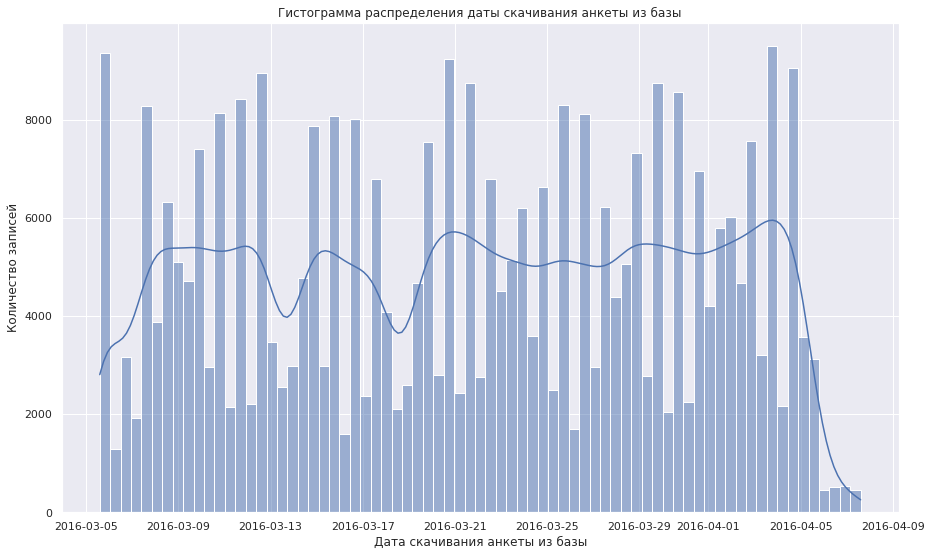

In [ ]:
sns.histplot(data=df, x='date_crawled', kde=True).set(
    title='Гистограмма распределения даты скачивания анкеты из базы',
    xlabel='Дата скачивания анкеты из базы',
    ylabel='Количество записей'
);

Чтож, чего-то такого и следовало ожидать. Данные скачивались с марта по апрель 2016 года включительно. В разные дни скачивалось разное количество записей. Данная переменная вряд ли будет полезна при моделировании, поэтому при подготовке выборок её нужно будет отбросить.

#### `price`
Посмотрим на распределение целевой переменной!

In [ ]:
df.price.describe().to_frame()

,price
count,354365.000000
mean,4416.679830
std,4514.176349
min,0.000000
25%,1050.000000
50%,2700.000000
75%,6400.000000
max,20000.000000


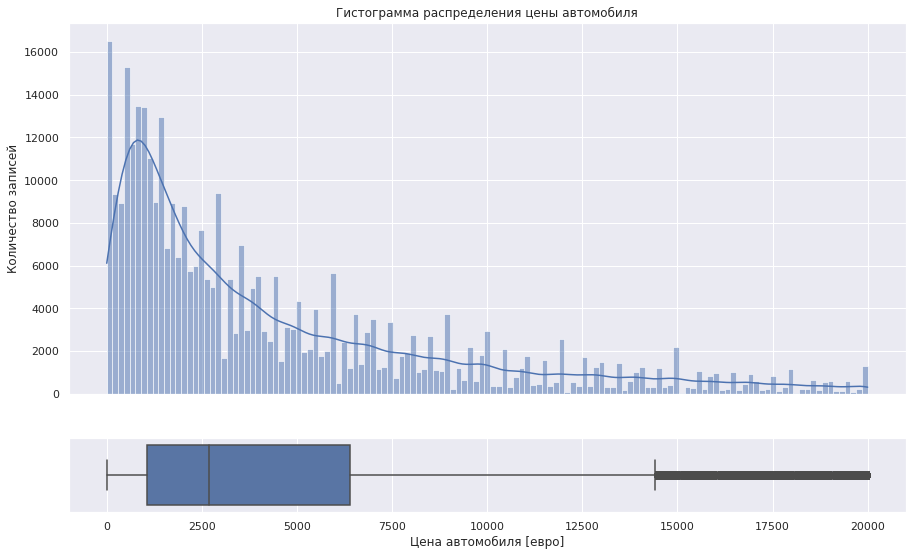

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=df, x='price', kde=True, ax=axs_hist)
box = sns.boxplot(data=df, x='price', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения цены автомобиля',
         ylabel='Количество записей')
box.set(xlabel='Цена автомобиля [евро]');

Ох. Гистограмма получилась красивая, но количество записей с нулевой или очень низкой ценой автомобиля вызывает тревогу. Может в данных ошибки? Или это автомобили в очень плохом состоянии, которые отдают на металлолом? Также виден большой правый "хвост" гистограммы. Возможно это автомобили класса люкс, но больше похоже на ошибочные значения. Например, кто-то указывал цену автомобиля и случайно ввёл лишний ноль.

Чтобы наша модель была более предсказуемой сформируем новую выборку, в которой отфильтруем 1 процент записей с самыми низкими ценами и 1 процент записей с самыми высокими ценами.

In [ ]:
low = df['price'].quantile(.01)
high = df['price'].quantile(.99)

In [ ]:
df_price_filtered = df[(df['price'] > low) & (df['price'] < high)].copy()

Посмотрим на отфильтрованные данные

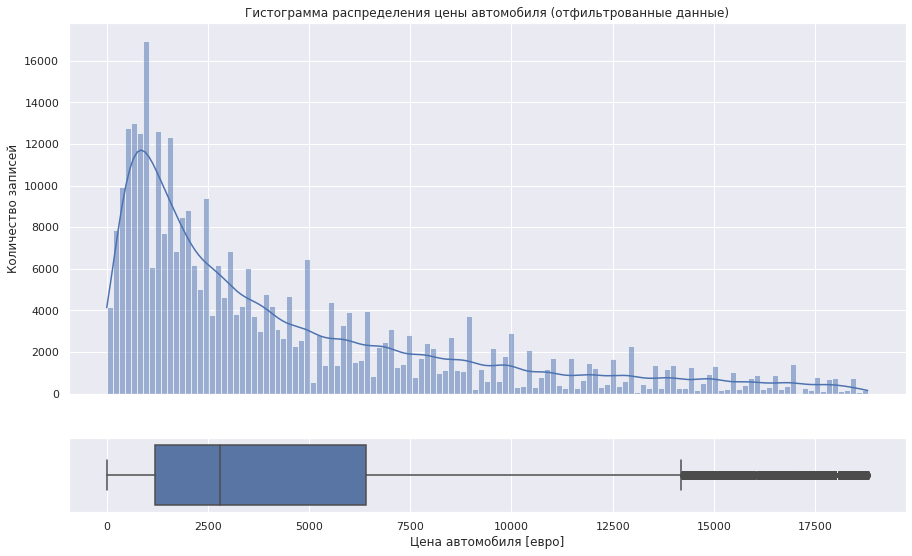

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=df_price_filtered, x='price', kde=True, ax=axs_hist)
box = sns.boxplot(data=df_price_filtered, x='price', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения цены автомобиля (отфильтрованные данные)',
         ylabel='Количество записей')
box.set(xlabel='Цена автомобиля [евро]');

Замечательно! Характер распределения не поменялся, а от подозрительных данных мы избавились!

#### `vehicle_type`

In [ ]:
df_price_filtered.vehicle_type\
.value_counts(normalize=True, dropna=False)\
.sort_values(ascending=False).to_frame()

,vehicle_type
sedan,0.260131
small,0.229164
wagon,0.185513
NaN,0.098969
bus,0.082330
convertible,0.056962
coupe,0.044657
suv,0.033246
other,0.009028


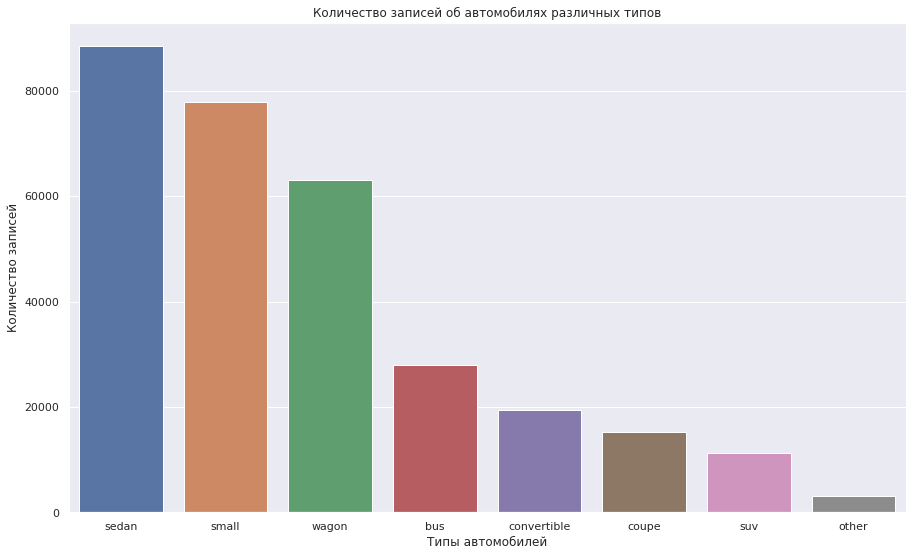

In [ ]:
t = df_price_filtered.vehicle_type.value_counts(dropna=False)
sns.barplot(x=t.index, y=t).set(
    title='Количество записей об автомобилях различных типов',
    xlabel='Типы автомобилей',
    ylabel='Количество записей'
);

В колонке `vehicle_type` у нас имеется довольно много (более десяти процентов) пропусков данных. Если мы заполним эти пропуски самым часто встречающимся значением (седан), то можем исказить результаты исследования. 

Давайте посмотрим, сможем ли мы заполнить пропуски исходя из меющейся информации о фирме-производителе (колнка `brand`). Можно предположить, что различные фирмы могут производить больше автомобилей определённых типов. Давайте сравним, какие типы автомобилей выпускает компания Volkswagen, а какие — Лада.

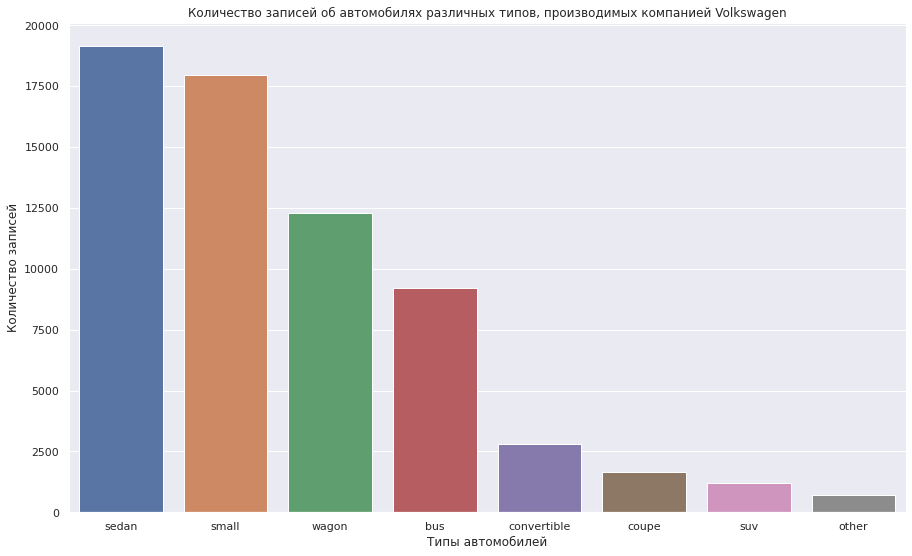

In [ ]:
volkswagen_types = \
df_price_filtered[df_price_filtered['brand'] == 'volkswagen'].vehicle_type\
.value_counts(dropna=False).sort_values(ascending=False)
sns.barplot(x=volkswagen_types.index, y=volkswagen_types).set(
    title='Количество записей об автомобилях различных типов, производимых компанией Volkswagen',
    xlabel='Типы автомобилей',
    ylabel='Количество записей'
);

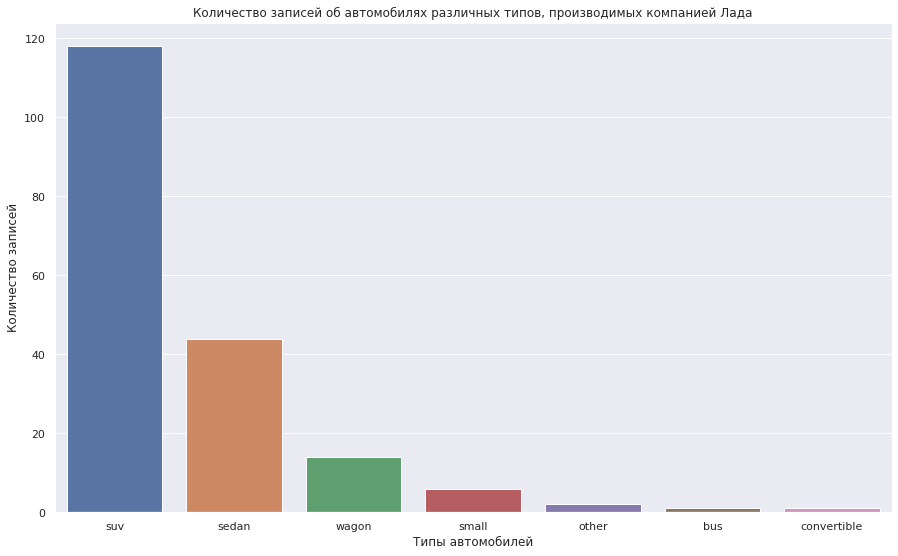

In [ ]:
lada_types = \
df_price_filtered[df_price_filtered['brand'] == 'lada'].vehicle_type\
.value_counts(dropna=False).sort_values(ascending=False)
sns.barplot(x=lada_types.index, y=lada_types).set(
    title='Количество записей об автомобилях различных типов, производимых компанией Лада',
    xlabel='Типы автомобилей',
    ylabel='Количество записей'
);

Видно, что исходя из имеющихся данных компания Volkswagen специализируется на автомобилях класса седан, а Лада — на внедорожниках. Отлично! Теперь мы можем заполнить пропуски данных более осмысленно.

In [ ]:
type_replacement_dict = df_price_filtered.groupby('brand')['vehicle_type']\
.agg(pd.Series.mode).to_dict()

In [ ]:
df_price_filtered.loc[
    df_price_filtered['vehicle_type'].isna(), 
    'vehicle_type'] = \
    df_price_filtered.loc[df['vehicle_type'].isna(), 'brand']\
    .map(type_replacement_dict)

In [ ]:
df_price_filtered.vehicle_type\
.value_counts(normalize=True, dropna=False)\
.sort_values(ascending=False).to_frame()

,vehicle_type
sedan,0.306373
small,0.272480
wagon,0.193544
bus,0.082662
convertible,0.057156
coupe,0.044657
suv,0.034099
other,0.009028


Ну вот. Мы удалили хитрые пропуски и, похоже, не сильно исказили данные.

#### `registration_year`

In [ ]:
df_price_filtered['registration_year'].describe().to_frame()

,registration_year
count,340036.000000
mean,2004.008711
std,77.311203
min,1000.000000
25%,1999.000000
50%,2003.000000
75%,2008.000000
max,9999.000000


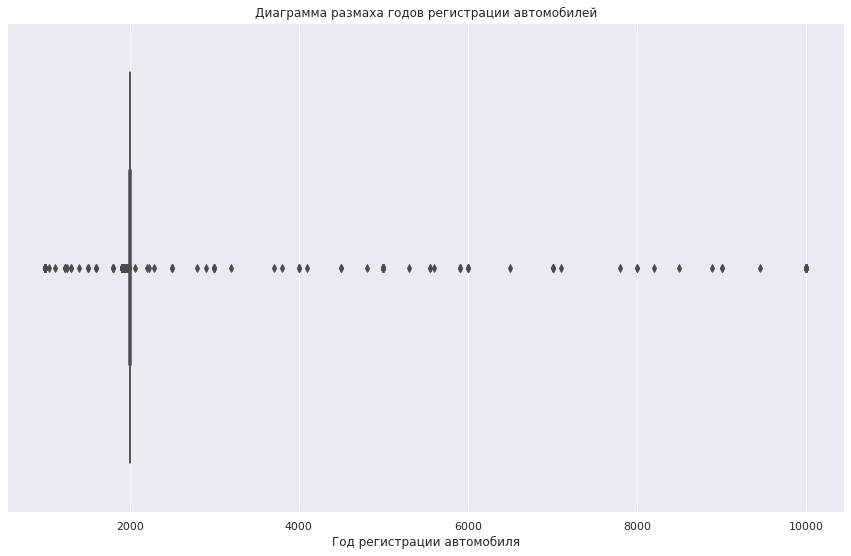

In [ ]:
sns.boxplot(data=df_price_filtered, x='registration_year', orient='h')\
.set(title='Диаграмма размаха годов регистрации автомобилей',
    xlabel='Год регистрации автомобиля');

Ой, какая красота. Некоторые автомобили были зарегистрированы в далёком будущем. А некоторые — ещё в 1000 году. Википедия [утверждает](https://ru.wikipedia.org/wiki/1000_%D0%B3%D0%BE%D0%B4), что именно этот год приблизительно разделяет в Старом Свете периоды Раннего Средневековья и Высокого Средневековья. Многие записи явно ошибочны, возможно робот, собиравший данные, "зацепил" не ту колонку.

Данная колонка скорее всего будет очень важна для модели, ведь год регистрации во многом определяет цену автомобиля. Давайте отбросим 2 процента наших данных, чтобы исключить наиболее явные ошибки.

In [ ]:
low_year = df_price_filtered['registration_year'].quantile(.01)
high_year = df_price_filtered['registration_year'].quantile(.99)

In [ ]:
df_filtered = \
df_price_filtered[(df_price_filtered['registration_year'] > low_year) &
                  (df_price_filtered['registration_year'] < high_year)].copy()

In [ ]:
df_filtered.registration_year.describe().to_frame()

,registration_year
count,332645.000000
mean,2003.293947
std,6.323189
min,1981.000000
25%,1999.000000
50%,2003.000000
75%,2007.000000
max,2017.000000


Отбрасывание двух процентов данных почти идеально почистило наши данные, но как мы помним, данные скачивались в 2016 году, а значит и 2017 год для нас - будущее. 

In [ ]:
df_filtered = df_filtered[df_filtered.registration_year < 2017].copy()

Ну чтож, давайте посмотрим на то, что у нас получилось.

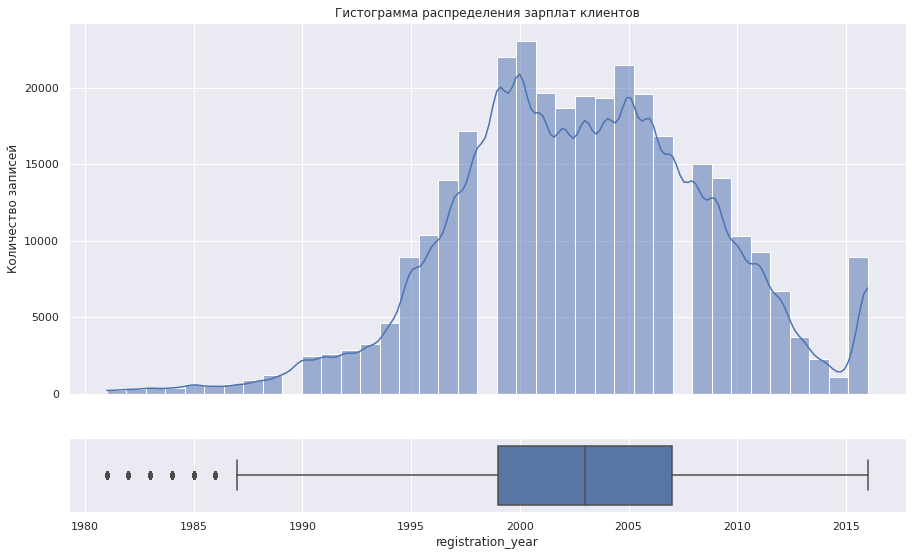

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = \
sns.histplot(data=df_filtered, x='registration_year', 
             kde=True, ax=axs_hist, bins=39)
box = sns.boxplot(data=df_filtered, x='registration_year', 
                  orient='h', ax=axs_box)
box.set(xlabel='Год регистрации')
hist.set(title='Гистограмма распределения годов регистрации автомобилей',
         ylabel='Количество записей');

Любо-дорого! Мы удалили все подозрительные данные, теперь наше распределение даже немного похоже на нормальное. Виден левый хвост, кто-то продаёт подержанные советские автомобили. Виден "всплеск" после 2015 года, возможно это связано с какими-то особенностями перепродажи автомобилей.

#### `gearbox`

In [ ]:
df_filtered.gearbox.value_counts(normalize=True, dropna=False)

manual    0.766506
auto      0.187544
NaN       0.045950
Name: gearbox, dtype: float64

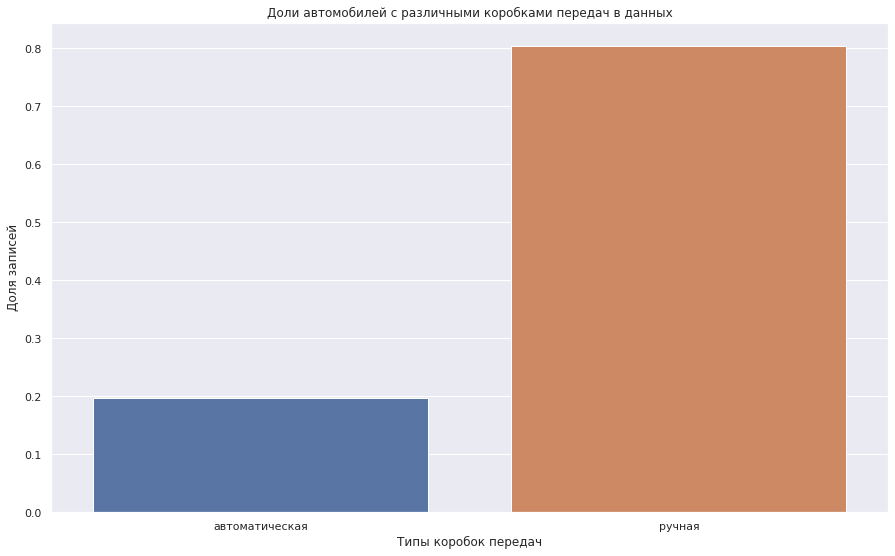

In [ ]:
t = df_filtered.gearbox.value_counts(normalize=True)
ax = sns.barplot(data=t, y=t, x=t.index)
ax.set_xticklabels(['автоматическая', 'ручная'])
ax.set(xlabel='Типы коробок передач', 
       ylabel='Доля записей',
       title='Доли автомобилей с различными коробками передач в данных');

В нашей таблице примерно 19 процентов данных относятся к машинам с автоматической коробкой передач, 76 процентов — к машинам с ручной коробкой передач. Примерно 5 процентов данных пропущено. Заполним их самым частым значением (ручная коробка передач).

In [ ]:
df_filtered['gearbox'] = df_filtered['gearbox'].fillna(value='manual')

Посмотрим на получившееся соотношение.

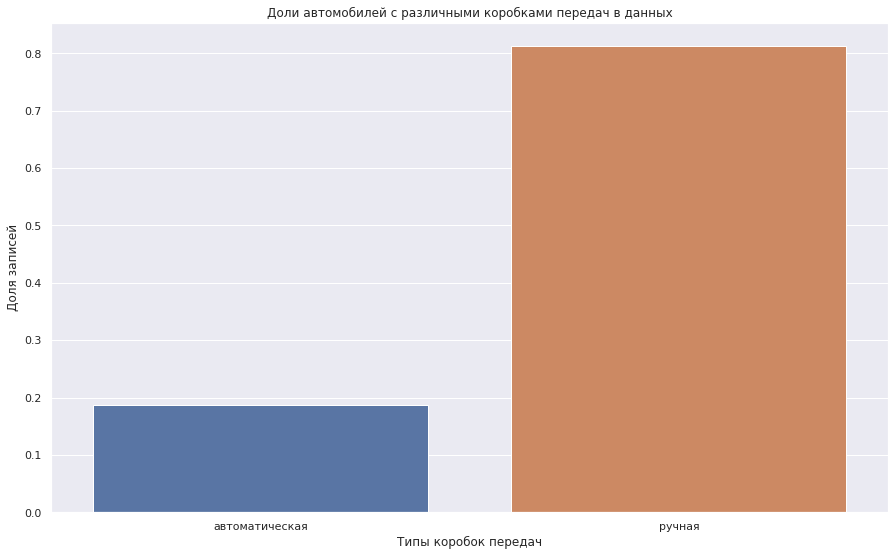

In [ ]:
t = df_filtered.gearbox.value_counts(normalize=True)
ax = sns.barplot(data=t, y=t, x=t.index)
ax.set_xticklabels(['автоматическая', 'ручная'])
ax.set(xlabel='Типы коробок передач', 
       ylabel='Доля записей',
       title='Доли автомобилей с различными коробками передач в данных');

Доля записей о машинах с ручной коробкой передач незначительно выросла, зато мы избавились от пропусков.

#### `power`

In [ ]:
df_filtered.power.describe().to_frame()

,power
count,322783.000000
mean,111.473727
std,184.069181
min,0.000000
25%,71.000000
50%,105.000000
75%,143.000000
max,20000.000000


Опять видно, что в данных содержится множесто ошибочных записей о мощности. Эта характеристика будет крайне важна для построения модели, поэтому отбросим два процента наиболее "выдающихся" записей.

In [ ]:
low_power = df_filtered['power'].quantile(0.01)
high_power = df_filtered['power'].quantile(0.99)

In [ ]:
low_power, high_power

(0.0, 299.0)

In [ ]:
df_filtered = df_filtered[
    (df_filtered['power'] > low_power) & 
    (df_filtered['power'] < high_power)
    ].copy()

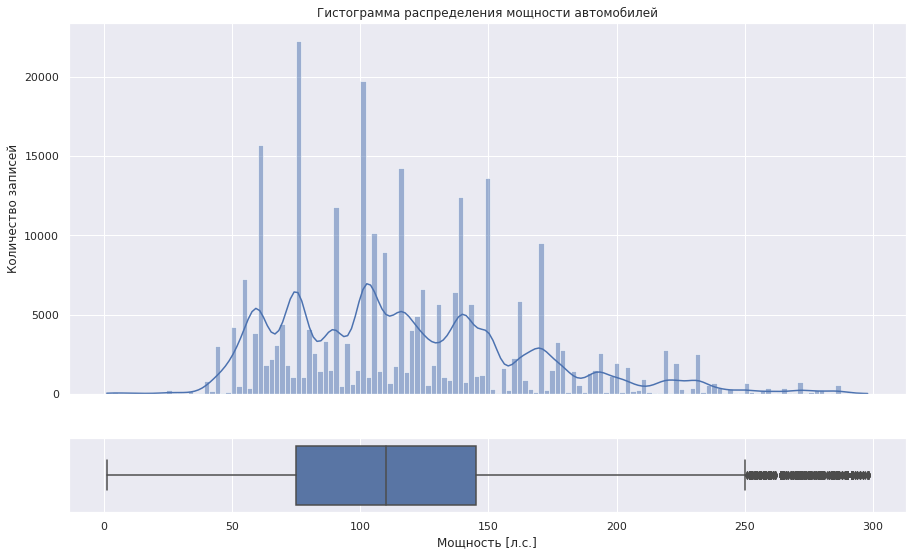

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = \
sns.histplot(data=df_filtered, x='power', 
             kde=True, ax=axs_hist)
box = sns.boxplot(data=df_filtered, x='power', orient='h', ax=axs_box)
box.set(xlabel='Мощность [л.с.]')
hist.set(title='Гистограмма распределения мощности автомобилей',
         ylabel='Количество записей');

После отбраковки части данных распределение мощности больше похоже на реальное. Наблюдается несколько пиков на значениях примерно 60, 70, 75... лошадиных сил. Возможно при составлении объявлений владельцы округляли значения мощности, или двигатели с определёнными значениями мощности более технологичны.

Проверим, насколько мощность связана с типом автомобиля и коробкой передач.

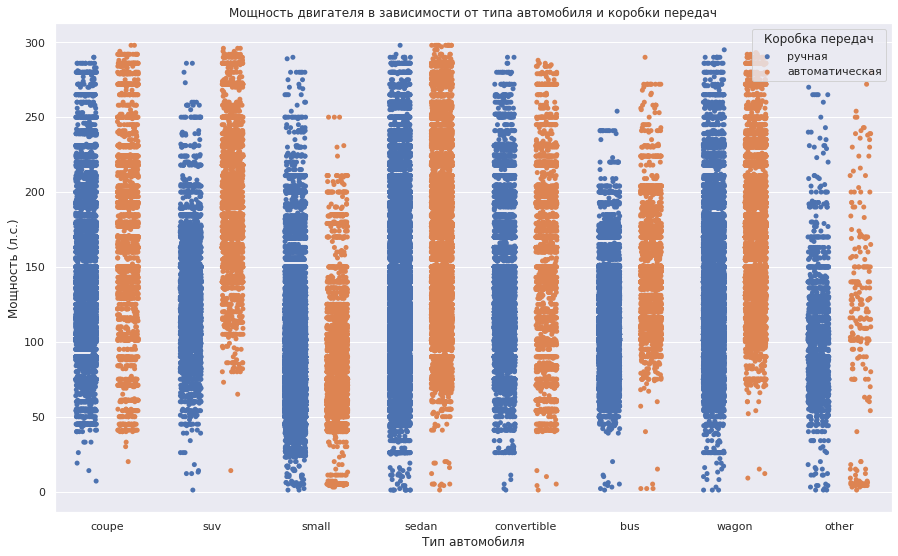

In [ ]:
sns.stripplot(data=df_filtered, x='vehicle_type', y='power', hue='gearbox',
              jitter=.2, dodge=True)\
              .set(
                  title='Мощность двигателя в зависимости от типа автомобиля и коробки передач',
                   xlabel='Тип автомобиля',
                   ylabel='Мощность (л.с.)'
              )
plt.legend(loc='upper right', title='Коробка передач', 
           labels=['ручная', 'автоматическая']);

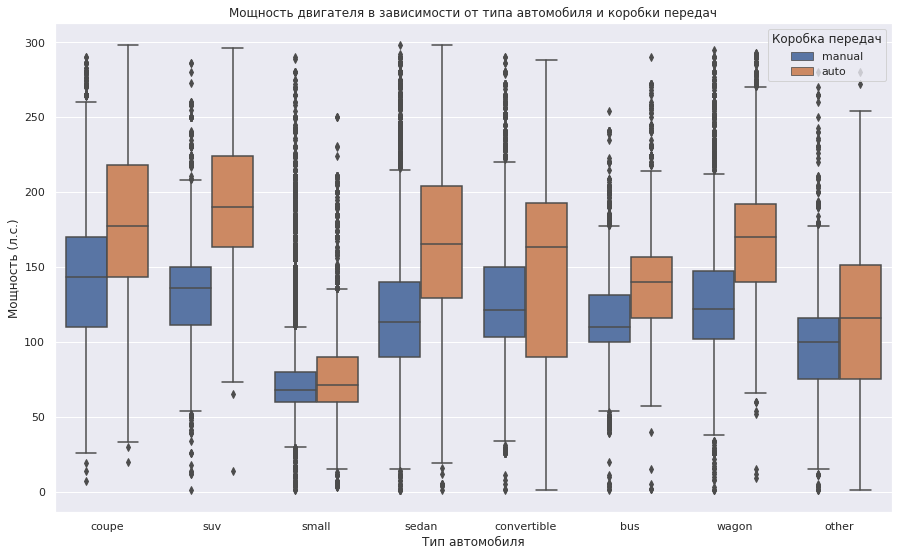

In [ ]:
sns.boxplot(data=df_filtered, x='vehicle_type', y='power', hue='gearbox',
              orient='v')\
              .set(
                  title='Мощность двигателя в зависимости от типа автомобиля и коробки передач',
                   xlabel='Тип автомобиля',
                   ylabel='Мощность (л.с.)'
              )
plt.legend(loc='upper right', title='Коробка передач'); 

Видно, что распределения мощности сильно меняются в зависимости от типа автомобиля и коробки передач. Например, внедорожники *(suv)* с автоматической коробкой передач как правило мощнее, чем с ручной. В целом подобные распределения довольно правдоподобны.

#### `model`

В столбце `model` содержатся пропуски данных. Посмотрим, сколько их.

In [ ]:
df_filtered.model.isna().mean()

0.036132815892880095

In [ ]:
len(df_filtered.model.unique())

249

In [ ]:
len(df[(df['brand'] == 'volkswagen') & 
       (df['vehicle_type'] == 'sedan')]['model'].unique())

21

Пропусков в столбце `model` всего 3.8% от общего количества данных. Много, но не критично. И этот столбец будет крайне важен для модели. Мы не видим возможности заполнить пропуски исходя из имеющихся данных: у одного Вольксвагена производится 21 модель. Придётся отбросить пропуски.

In [ ]:
df_filtered = df_filtered.dropna(axis=0, subset=['model'])

In [ ]:
# check
df_filtered.model.isna().mean()

0.0

Мы отбросили записи с пропусками данных, у нас остались данные о 249 моделях. Они пригодятся нам при обучении моделей.

#### `kilometer`

In [ ]:
df_filtered.kilometer.describe()

count    277427.000000
mean     128909.983527
std       36060.779879
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [ ]:
df_filtered.kilometer.isna().sum()

0

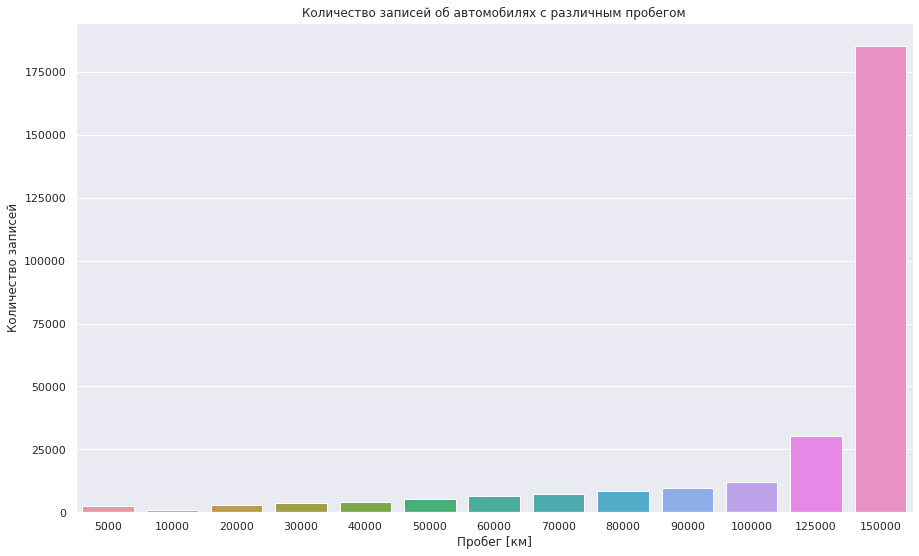

In [ ]:
sns.countplot(data=df_filtered, x='kilometer')\
.set(title='Количество записей об автомобилях с различным пробегом',
    xlabel='Пробег [км]',
    ylabel='Количество записей');

В данной колонке не наблюдается ни пропусков данных, ни подозрительных значений переменной. Наблюдается ярко выраженная мода в районе 150 тысяч километров, что естественно для подержаных авто. Возможно сайт, с которого собирались данные, не позволял вводить больший пробег и 150 тысяч вобрали в себя автомобили с большим пробегом.

#### `registration_month`

In [ ]:
df_filtered.registration_month.describe().to_frame()

,registration_month
count,277427.000000
mean,6.030826
std,3.570441
min,0.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,12.000000


In [ ]:
df_filtered.registration_month.isna().sum()

0

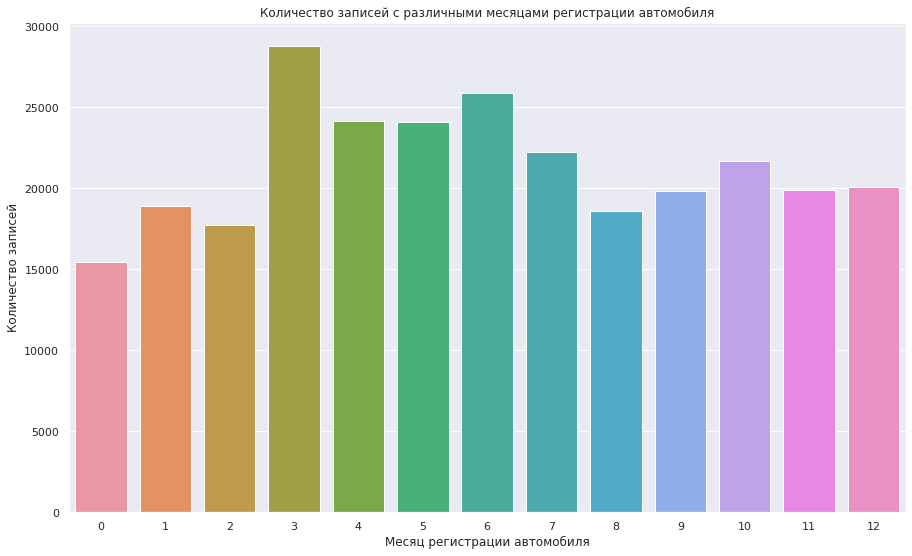

In [ ]:
sns.countplot(data=df_filtered, x='registration_month')\
.set(xlabel='Месяц регистрации автомобиля',
     ylabel='Количество записей',
     title='Количество записей с различными месяцами регистрации автомобиля');

Видно, что в данных наблюдается забавная проблема: в году всего 12 месяцев, а у нас их 13! Возможно один месяц прибавился из-за неправильной интерпретации данных (например, в пайтоне нумерация элементов списка начинается с нуля, что путает начинающих программистов). Против этой гипотезы говорит то, что если сложить данные за нулевой и первый месяц получится подозрительный выброс. С другой стороны, может автомобилистам по каким-то причинам предпочтительнее регистрировать машины в январе. 

В любом случае этот столбец вряд-ли будет полезен для обучения модели, поэтому оставим его без изменений, так как при формировании финальной выборки он будет удалён.

#### `fuel_type`

In [ ]:
df_filtered.fuel_type.value_counts(normalize=True, dropna=False)\
.sort_values(ascending=False).to_frame()

,fuel_type
petrol,0.634945
gasoline,0.301831
NaN,0.045533
lpg,0.014962
cng,0.001680
hybrid,0.000627
other,0.000223
electric,0.000198


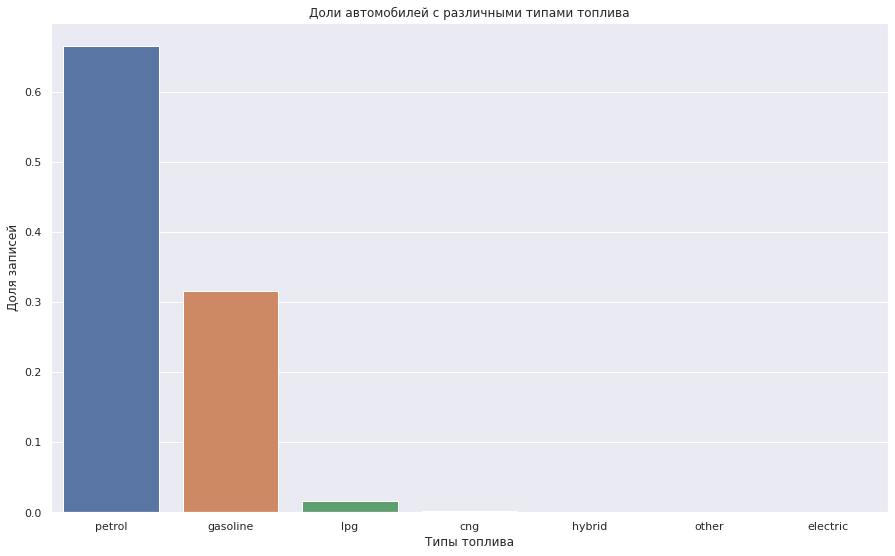

In [ ]:
t = df_filtered.fuel_type.value_counts(normalize=True)\
.sort_values(ascending=False).to_frame()
ax = sns.barplot(data=t, y='fuel_type', x=t.index)

ax.set(xlabel='Типы топлива', 
       ylabel='Доля записей',
       title='Доли автомобилей с различными типами топлива');

Итак, большинство автомобилей используют в качестве топлива *petrol* или *gasoline*. У нас имеется более пяти процентов пропусков данных. Заполним их исходя из информации о типе автомобиля.

In [ ]:
fuel_dict = df_filtered.groupby('vehicle_type')['fuel_type']\
.agg(pd.Series.mode).to_dict()

In [ ]:
fuel_dict

{'bus': 'gasoline',
 'convertible': 'petrol',
 'coupe': 'petrol',
 'other': 'gasoline',
 'sedan': 'petrol',
 'small': 'petrol',
 'suv': 'gasoline',
 'wagon': 'gasoline'}

In [ ]:
df_filtered.loc[
    df_filtered['fuel_type'].isna(), 
    'fuel_type'] = \
    df_filtered.loc[df['fuel_type'].isna(), 'vehicle_type'].map(fuel_dict)

In [ ]:
df_filtered.fuel_type.value_counts(normalize=True, dropna=False)\
.sort_values(ascending=False).to_frame()

,fuel_type
petrol,0.668598
gasoline,0.313711
lpg,0.014962
cng,0.001680
hybrid,0.000627
other,0.000223
electric,0.000198


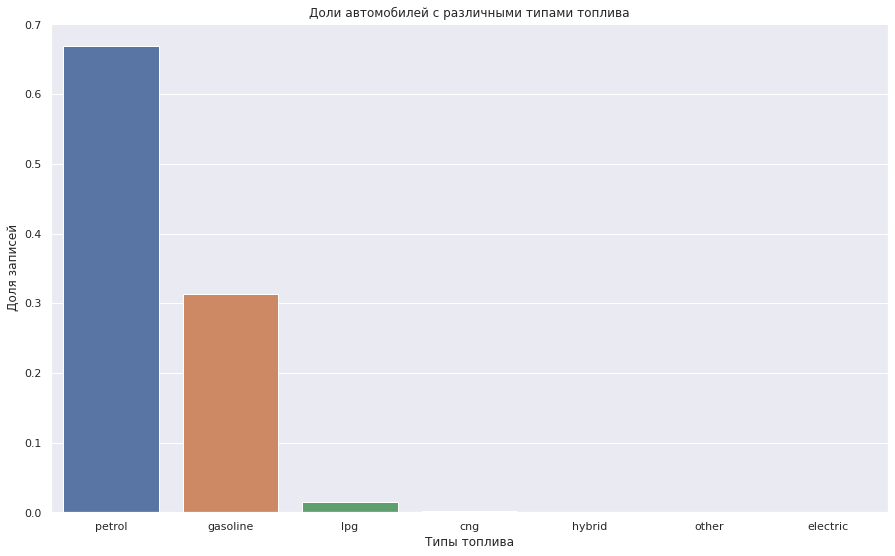

In [ ]:
t = df_filtered.fuel_type.value_counts(normalize=True)\
.sort_values(ascending=False).to_frame()
ax = sns.barplot(data=t, y='fuel_type', x=t.index)

ax.set(xlabel='Типы топлива', 
       ylabel='Доля записей',
       title='Доли автомобилей с различными типами топлива');

Отлично. Мы обработали пропуски данных, так что соотношение типов топлива изменилось незначительно. Других проблем с данной колонкой не наблюдается.

#### `brand`

In [ ]:
len(df_filtered.brand.unique())

39

In [ ]:
df_filtered.brand.value_counts(normalize=True, dropna=False)

volkswagen       0.219110
opel             0.111896
bmw              0.107711
mercedes_benz    0.089793
audi             0.085194
ford             0.071367
renault          0.048589
peugeot          0.031940
fiat             0.026165
seat             0.020416
skoda            0.017345
mazda            0.016224
smart            0.015665
citroen          0.014638
toyota           0.013950
nissan           0.013860
hyundai          0.010673
mini             0.010219
volvo            0.009613
mitsubishi       0.008550
honda            0.008143
kia              0.007151
suzuki           0.006798
alfa_romeo       0.006686
chevrolet        0.004671
chrysler         0.003878
dacia            0.002837
subaru           0.002210
daihatsu         0.002159
jeep             0.001853
saab             0.001622
land_rover       0.001507
daewoo           0.001388
jaguar           0.001326
lancia           0.001272
porsche          0.001240
rover            0.001153
trabant          0.000692
lada        

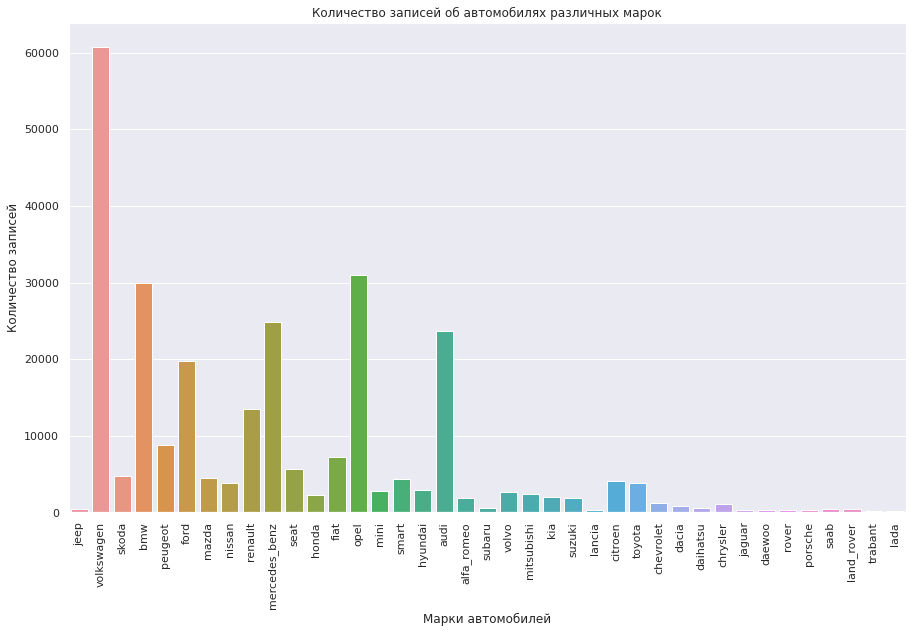

In [ ]:
sns.countplot(data=df_filtered, x='brand')\
.set(xlabel='Марки автомобилей',
     ylabel='Количество записей',
     title='Количество записей об автомобилях различных марок')
plt.xticks(rotation=90);

В данной колонке нет пропусков данных и подозрительных значений. У нас имеются данные об автомобилях 39 марок. Большинство автомобилей произведено компанией Вольксваген, за ней следуют Опель, БМВ, Ауди и Мерседес. Эта колонка будет весьма полезна при обучении модели.

#### `not_repaired`

In [ ]:
df.not_repaired.value_counts(normalize=True, dropna=False).to_frame()

,not_repaired
no,0.697467
NaN,0.200793
yes,0.101740


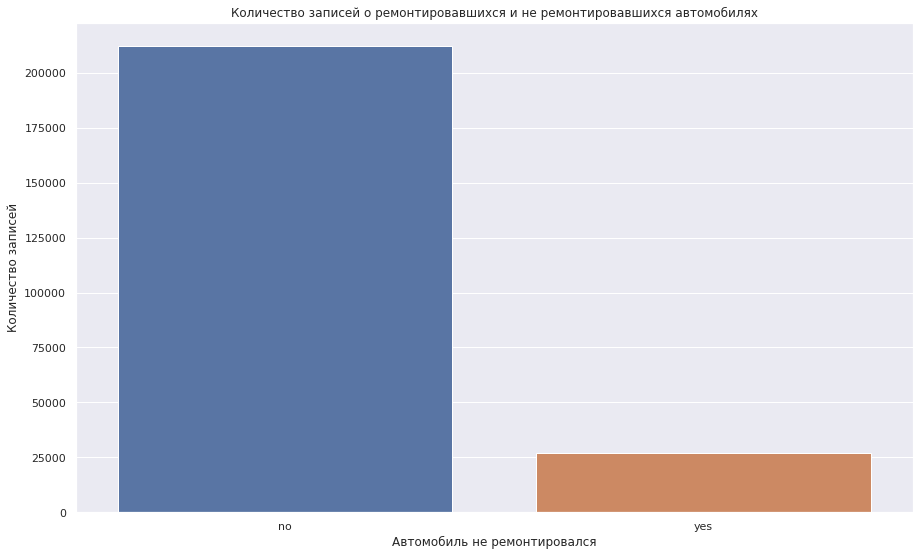

In [ ]:
ax = sns.countplot(data=df_filtered, x='not_repaired')
ax.set(title='Количество записей о ремонтировавшихся и не ремонтировавшихся автомобилях',
     xlabel='Автомобиль не ремонтировался',
     ylabel='Количество записей');

Видно, что в имеющихся данных больше всего данных о не ремонтировавшихся автомобилях. У нас также имеется примерно 20 процентов данных с пропусками. Пропусков очень много, так что просто отбросить данные мы не можем. Колонка очень важная для определения стоимости автомобиля, заполнение пропусков самым часто встречающися значением может привести к сильным искажениям. Поэтому отметим все пропуски значением *unknown* (неизвестно).

In [ ]:
df_filtered.not_repaired = df_filtered.not_repaired.fillna(value='unknown')

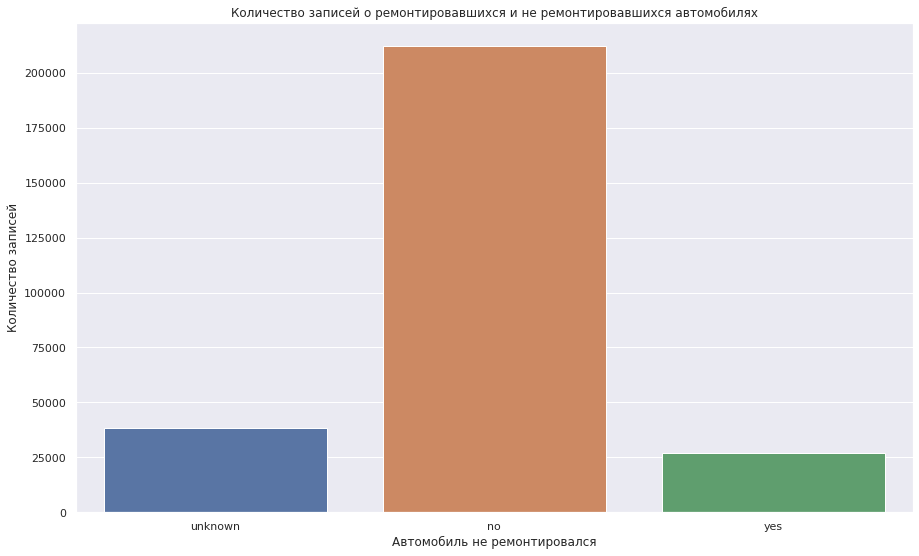

In [ ]:
ax = sns.countplot(data=df_filtered, x='not_repaired')
ax.set(title='Количество записей о ремонтировавшихся и не ремонтировавшихся автомобилях',
     xlabel='Автомобиль не ремонтировался',
     ylabel='Количество записей');

Мы обработали пропуски, не потеряли значительную часть данных, колонка готова для обучения!

#### `date_created`

Изменим формат данных.

In [ ]:
df_filtered.date_created = pd.to_datetime(df_filtered.date_created, 
                                          format='%Y-%m-%d %H:%M:%S')

In [ ]:
# check
df_filtered.dtypes.to_frame()

,0
date_crawled,datetime64[ns]
price,int64
vehicle_type,object
registration_year,int64
gearbox,object
power,int64
model,object
kilometer,int64
registration_month,int64
fuel_type,object


In [ ]:
df_filtered.date_created.describe(datetime_is_numeric=True).to_frame()

,date_created
count,277427
mean,2016-03-20 19:16:19.548494080
min,2015-03-20 00:00:00
25%,2016-03-13 00:00:00
50%,2016-03-21 00:00:00
75%,2016-03-29 00:00:00
max,2016-04-07 00:00:00


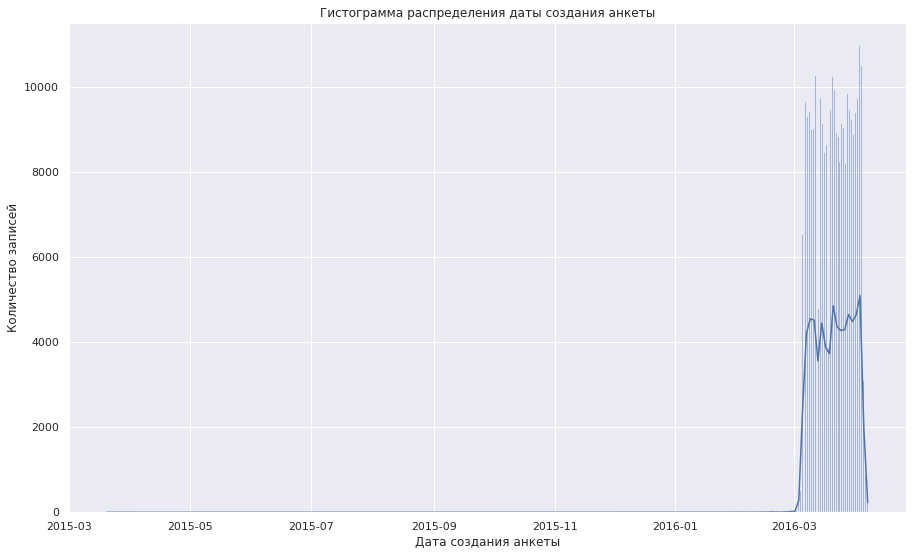

In [ ]:
sns.histplot(data=df_filtered, x='date_created', kde=True).set(
    title='Гистограмма распределения даты создания анкеты',
    xlabel='Дата создания анкеты',
    ylabel='Количество записей'
);

Видно, что большая часть анкет создавалась в период с марта по апрель 2016 года, а небольшое количество было создано в марте 2015 года (возможно это ошибка чтения даты). Пропусков данных и других проблем в данной колонке не обнаружено.

Здравый смысл подсказывает, что дата создания анкеты вряд ли будет полезна при определении стоимости автомобиля.

#### `number_of_pictures`

In [ ]:
df_filtered.number_of_pictures.describe().to_frame()

,number_of_pictures
count,277427.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [ ]:
df_filtered.number_of_pictures.value_counts(normalize=True).to_frame()

,number_of_pictures
0,1.0


Ой какая интересная колонка. Похоже, что во всех записях отсутствуют фотографии. Жаль, было бы интересно посмотреть, как изменяется количество фотографий в зависимости от, например, ремонта автомобиля.В нашем случае данную колонку не получится использовать при обучении модели.

#### `postal_code`

In [ ]:
df_filtered.postal_code.describe().to_frame()

,postal_code
count,277427.000000
mean,51265.892195
std,25754.244701
min,1067.000000
25%,30952.000000
50%,50354.000000
75%,72108.000000
max,99998.000000


In [ ]:
len(df_filtered.postal_code.unique())

8101

В данной колонке 8104 уникальных почтовых индекса владельцев анкет. Пропусков данных нет, колонка прекрасна, но не пригодится при обучении модели.

#### `last_seen`

Изменим формат данных.

In [ ]:
df_filtered.last_seen = pd.to_datetime(df_filtered.last_seen, 
                                          format='%Y-%m-%d %H:%M:%S')

In [ ]:
# check
df_filtered.dtypes.to_frame()

,0
date_crawled,datetime64[ns]
price,int64
vehicle_type,object
registration_year,int64
gearbox,object
power,int64
model,object
kilometer,int64
registration_month,int64
fuel_type,object


In [ ]:
df_filtered.last_seen.describe(datetime_is_numeric=True).to_frame()

,last_seen
count,277427
mean,2016-03-30 04:22:51.663345920
min,2016-03-05 14:15:08
25%,2016-03-23 12:42:12
50%,2016-04-03 23:47:36
75%,2016-04-06 10:45:36
max,2016-04-07 14:58:51


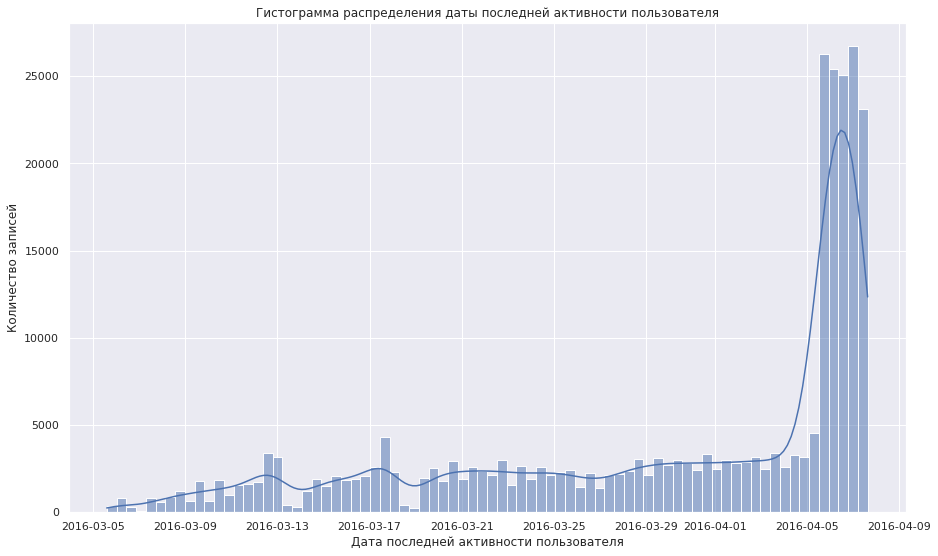

In [ ]:
sns.histplot(data=df_filtered, x='last_seen', kde=True).set(
    title='Гистограмма распределения даты последней активности пользователя',
    xlabel='Дата последней активности пользователя',
    ylabel='Количество записей'
);

Переменная `last_seen` не содержит пропусков данных. Распределение имеет левый хвост, большая часть пользователей проявляли активность с пятого по седьмое апреля.

Данная колонка скорее всего не будет использоваться при обучении модели.

### Финальная подготовка данных

На этапе исследовательского данных мы обнаружили, что некоторые колонки не пригодятся для обучения модели. Сформируем отдельный датасет, по которому и будем проводить обучение. Включим в него колонки `price`, `vehicle_type`, `registration_year`, `gearbox`, `power`, `model`, `kilometer`, `fuel_type`, `brand`, `not_repaired`.

In [ ]:
learn = df_filtered[['price', 'vehicle_type', 'registration_year', 
                     'gearbox', 'power', 'model', 'kilometer', 
                     'fuel_type', 'brand', 'not_repaired']]

<div class="alert alert-success">
<b>2 Комментарий ревьюера ✔️:</b> 

Все неинформативные признаки удалены!

### Промежуточные выводы

Мы провели исследовательский анализ, обаботку и финальную подготовку данных.

В процессе исследовательского анализа были выявлены и устранены некоторые проблемы с данными. В ряде колонок были обнаружены и обработаны пропуски данных. Часть колонок содержали небольшое количество подозрительных или явно ошибочных данных. Такие данные пришлось удалить, чтобы они не исказили результаты работы уже обученной модели.

На этапе финальной подготовки данных были отобраны колоноки, которые будут использоваться для обучения модели. Остальные колонки были отброшены, так как содержащиеся в них данные явно не связаны с определением ценой автомобиля.

## Обучение моделей

Пришло время обучить наши модели. Сначала разделим данные на обучающую и тестовую выборки в соотношении 80% на 20%.

In [ ]:
X = learn[['vehicle_type', 'registration_year', 
                     'gearbox', 'power', 'model', 'kilometer', 
                     'fuel_type', 'brand', 'not_repaired']]
y = learn['price']

In [ ]:
RANDOM_STATE = 42

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RANDOM_STATE, 
                                                    shuffle=True)

Теперь выделим из учебной выборки 20 процентов на валидацию.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=RANDOM_STATE, 
                                                  shuffle=True)

Данные разделены, теперь можно попробовать обучить на них несколько моделей.

### CatBoost

In [ ]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 
                'brand', 'not_repaired']

In [ ]:
train_dataset = cb.Pool(X_train, y_train, cat_features=cat_features) 
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
val_dataset = cb.Pool(X_val, y_val, cat_features=cat_features) 

In [ ]:
cb_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    task_type='GPU',
    verbose=False
)

In [ ]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 8]}

In [ ]:
%%time
grid_search_result  = cb_model.grid_search(grid, train_dataset)

bestTest = 1712.042919
bestIteration = 999
0:	loss: 1712.0429189	best: 1712.0429189 (0)	total: 13.5s	remaining: 1m 7s
bestTest = 1625.106832
bestIteration = 999
1:	loss: 1625.1068315	best: 1625.1068315 (1)	total: 36.1s	remaining: 1m 12s
bestTest = 1583.765473
bestIteration = 999
2:	loss: 1583.7654729	best: 1583.7654729 (2)	total: 1m 12s	remaining: 1m 12s
bestTest = 1533.194701
bestIteration = 999
3:	loss: 1533.1947011	best: 1533.1947011 (3)	total: 1m 40s	remaining: 50.3s
bestTest = 1537.890607
bestIteration = 995
4:	loss: 1537.8906071	best: 1533.1947011 (3)	total: 2m 30s	remaining: 30.1s
bestTest = 1503.767615
bestIteration = 999
5:	loss: 1503.7676153	best: 1503.7676153 (5)	total: 3m 12s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
bestTest = 1491.778359
bestIteration = 998
Training on fold [1/3]
bestTest = 1479.602311
bestIteration = 999
Training on fold [2/3]
bestTest = 1500.413018
bestIteration = 997
CPU times: user 6min 13s, sys: 1min 47s, total: 8min 1s
Wall t

Модель CatBoost на кросс-валидации обеспечила метрику RMSE 1479 за 6 минут 7 секунд. Посмотрим, какое значение RMSE модель выдаст на валидационных данных.

In [ ]:
cb_predict = cb_model.predict(val_dataset)

In [ ]:
mean_squared_error(y_val, cb_predict, squared=False)

1408.5870939668405

Заказчику важно время обучения и время предсказаний модели. Чтобы замерить это время обучим модель на валидационной выборке, а затем получим предсказания на ней же.

In [ ]:
grid_search_result['params']

{'depth': 8, 'learning_rate': 0.1}

In [ ]:
cb_model_val = cb.CatBoostRegressor(
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    task_type='GPU',
    depth=8,
    learning_rate=0.1,
    verbose=100
)

In [ ]:
%%time
cb_model_val.fit(val_dataset)

0:	learn: 3996.5102564	total: 46ms	remaining: 46s
100:	learn: 1547.4920593	total: 5.46s	remaining: 48.6s
200:	learn: 1482.7164641	total: 10.7s	remaining: 42.4s
300:	learn: 1455.0054273	total: 15.6s	remaining: 36.3s
400:	learn: 1439.6742048	total: 20.6s	remaining: 30.8s
500:	learn: 1431.1121341	total: 25.6s	remaining: 25.5s
600:	learn: 1420.7443156	total: 30.6s	remaining: 20.3s
700:	learn: 1411.6698379	total: 35.6s	remaining: 15.2s
800:	learn: 1404.0581096	total: 40.7s	remaining: 10.1s
900:	learn: 1398.9597363	total: 45.6s	remaining: 5s
999:	learn: 1395.7141790	total: 50.5s	remaining: 0us
CPU times: user 56.2 s, sys: 15 s, total: 1min 11s
Wall time: 51.3 s


In [ ]:
%%time
cb_model_val.predict(val_dataset)

CPU times: user 1.59 s, sys: 157 ms, total: 1.74 s
Wall time: 895 ms


array([ 1859.33179496, 13618.10986799,  8377.51769167, ...,
        5801.09964209,  4282.45014014,  6330.44206405])

Модель на основе CatBoost обучалась 51 секунду, время предсказаний составило 859 миллисекунд.

| Модель         | Время обучения     | Время предсказаний | RMSE (вал.) |
|:--------------|-----------|------------|------------|
| CatBoost | 51 сек | 859 миллисек  | 1408 |

### Нейросеть

Поробуем обучить нейросеть.

In [ ]:
nn_dataset = pd.concat([X_test, y_test], axis=1)

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(nn_dataset))

In [ ]:
to = TabularPandas(nn_dataset, procs=[Categorify, Normalize],
                   cat_names = cat_features,
                   cont_names = ['power', 'kilometer', 'registration_year'],
                   y_names='price',
                   splits=splits)

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
learner = tabular_learner(dls, metrics=rmse)

In [ ]:
%%time
learner.fit(20)

epoch,train_loss,valid_loss,_rmse,time
0,39418760.000000,38140976.000000,6175.839355,00:09
1,36536596.000000,34977612.000000,5914.188477,00:09
2,30287048.000000,30443984.000000,5517.606934,00:06
3,24761396.000000,24694948.000000,4969.401855,00:06
4,20555118.000000,18573796.000000,4309.733398,00:06
5,13792927.000000,13303886.000000,3647.449219,00:06
6,10091179.000000,8536538.000000,2921.735352,00:06
7,5952710.500000,5989900.000000,2447.427002,00:06
8,4031028.500000,3861549.500000,1965.082397,00:06
9,3114175.250000,2707009.500000,1645.299316,00:06


CPU times: user 2min 12s, sys: 1.71 s, total: 2min 14s
Wall time: 2min 19s


In [ ]:
val_df = X_val.copy()
dl = learner.dls.test_dl(val_df)

In [ ]:
%%time
y_pred_nn, _ = learner.get_preds(dl=dl)

CPU times: user 2.44 s, sys: 16.9 ms, total: 2.45 s
Wall time: 2.45 s


In [ ]:
mean_squared_error(y_val, y_pred_nn, squared=False)

1604.265890658827

Для нейронной сети обучение заняло 2 минуты 19 секунд, предсказание получено за 3 секунды, метрика RMSE равна 1604.

| Модель         | Время обучения     | Время предсказаний | RMSE (вал.) |
|:--------------|-----------|------------|------------|
| CatBoost | 51 сек | 859 миллисек  | 1408 |
| Нейросеть | 2 мин 19 cсек | 3 сек  | 1604 |

### LightGBM

Наконец, посмотрим на библиотеку LightGBM.

In [ ]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
X_val_lgbm = X_val.copy()

In [ ]:
for feature in cat_features:
    X_train_lgbm[feature] = pd.Series(X_train_lgbm[feature], dtype='category')
    X_test_lgbm[feature] = pd.Series(X_test_lgbm[feature], dtype='category')
    X_val_lgbm[feature] = pd.Series(X_val_lgbm[feature], dtype='category')

In [ ]:
def objective(trial):
  X_train_l, X_val_l, y_train_l, y_val_l = train_test_split(X_train_lgbm, y_train, test_size = 0.2)
  dtrain = lgbm.Dataset(X_train_l, label=y_train_l)

  param = {
      'metric': 'root_mean_squared_error',
      'random_state': RANDOM_STATE,
      'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1),
      'max_depth': trial.suggest_int('max_depth', 2, 8),
  }

  gbm = lgbm.train(param, dtrain)
  y_pred_l = gbm.predict(X_val_l)
  rmse = mean_squared_error(y_val_l, y_pred_l, squared=False)
  return rmse


In [ ]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2022-10-09 09:11:25,949] A new study created in memory with name: no-name-b37ce148-0b2a-480e-b5d1-74b781c6fbd3
[I 2022-10-09 09:11:27,620] Trial 0 finished with value: 1483.7474123329662 and parameters: {'learning_rate': 0.06449649281748474, 'max_depth': 7}. Best is trial 0 with value: 1483.7474123329662.
[I 2022-10-09 09:11:28,632] Trial 1 finished with value: 1819.8809752542284 and parameters: {'learning_rate': 0.03523915909421574, 'max_depth': 3}. Best is trial 0 with value: 1483.7474123329662.
[I 2022-10-09 09:11:30,147] Trial 2 finished with value: 1487.5314291683212 and parameters: {'learning_rate': 0.09019793240788189, 'max_depth': 7}. Best is trial 0 with value: 1483.7474123329662.
[I 2022-10-09 09:11:31,579] Trial 3 finished with value: 1635.947544574409 and parameters: {'learning_rate': 0.08141408867002695, 'max_depth': 3}. Best is trial 0 with value: 1483.7474123329662.
[I 2022-10-09 09:11:34,529] Trial 4 finished with value: 1508.1679434001003 and parameters: {'learning_

CPU times: user 2min 29s, sys: 720 ms, total: 2min 30s
Wall time: 2min 33s


Модель на основе LightGDM на кросс-валидации обеспечила метрику 1449. Подбор гипер-параметров занял 2 минуты 35 секунд.

In [ ]:
model_lgbm = lgbm.LGBMRegressor(random_state=RANDOM_STATE,
                                metric='root_mean_squared_error',
                                learning_rate=0.0956621333321235,
                                max_depth=7
                                )

In [ ]:
%%time
model_lgbm.fit(X_train_lgbm, y_train)

CPU times: user 1.42 s, sys: 15.4 ms, total: 1.44 s
Wall time: 1.43 s


LGBMRegressor(learning_rate=0.0956621333321235, max_depth=7,
              metric='root_mean_squared_error', random_state=42)

In [ ]:
y_pred_lgbm = model_lgbm.predict(X_val_lgbm)

In [ ]:
mean_squared_error(y_val, y_pred_lgbm, squared=False)

1460.9182786627225

На валидационной выборке LightGBM обеспечивает RMSE 1461. Для сравнения с другими моделями измерим время обучения и предсказания.

In [ ]:
%%time
model_lgbm.fit(X_val_lgbm, y_val)

CPU times: user 418 ms, sys: 3.34 ms, total: 421 ms
Wall time: 420 ms


LGBMRegressor(learning_rate=0.0956621333321235, max_depth=7,
              metric='root_mean_squared_error', random_state=42)

In [ ]:
%%time
model_lgbm.predict(X_val_lgbm)

CPU times: user 371 ms, sys: 0 ns, total: 371 ms
Wall time: 373 ms


array([ 1660.83352357, 13584.10407845,  8794.08863012, ...,
        5611.9926065 ,  4462.93306646,  6774.05166434])

Модель LightGBM обучилась за 420 миллисекунд, выдала предсказания за 371 миллисекунду.

| Модель         | Время обучения     | Время предсказаний | RMSE (вал.) |
|:--------------|-----------|------------|------------|
| CatBoost | 51 сек | 859 миллисек  | 1408 |
| Нейросеть | 2 мин 19 cсек | 3 сек  | 1604 |
| LightGBM | 420 миллисек  | 371 миллисек  | 1461 |

Похоже, что модель на основе LightGBM обучается и предсказывает значительно быстрее своих конкурентов и лишь немного уступает модели CatBoost в точности предсказаний. Посчитаем для LightGBM значение метрики на тестовой выборке.

In [ ]:
X_train_fin = pd.concat([X_train, X_val])
y_train_fin = pd.concat([y_train, y_val])

In [ ]:
for feature in cat_features:
    X_train_fin[feature] = pd.Series(X_train_fin[feature], dtype='category')

In [ ]:
model_lgbm.fit(X_train_fin, y_train_fin)

LGBMRegressor(learning_rate=0.0956621333321235, max_depth=7,
              metric='root_mean_squared_error', random_state=42)

In [ ]:
%%time
y_pred_lgbm = model_lgbm.predict(X_test_lgbm)

CPU times: user 470 ms, sys: 59 µs, total: 471 ms
Wall time: 470 ms


In [ ]:
mean_squared_error(y_test, y_pred_lgbm, squared=False)

1470.9016968469855

На тестовой выборке значение RMSE для модели LightGBM составило 1471. Предсказания были получены за 470 миллисекунд.

### DummyModel

Чтобы убедиться, что наши модели действительно работают, сравним их с "глупой" моделью, которая всегда будет предсказывать среднее значение цены.

In [ ]:
model_d = DummyRegressor()

In [ ]:
%%time
model_d.fit(X_train, y_train)

CPU times: user 1.24 ms, sys: 56 µs, total: 1.3 ms
Wall time: 863 µs


DummyRegressor()

In [ ]:
%%time
y_pred_d = model_d.predict(X_test)

CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 978 µs


In [ ]:
mean_squared_error(y_test, y_pred_d, squared=False)

4303.993780714567

Модель обучилась быстро, а вот значение метрики значительно хуже, чем у всех остальных моделей. А значит все наши модели обучились и прошли проверку на адекватность.

## Анализ моделей

Итак, в рамках данного проекта мы обучили четыре модели. Заказчика интересует время обучения, время предсказаний и значения метрики RMSE.

Давайте ещё раз сведём интересующие нас показатели в единую таблицу.



| Модель         | Время обучения     | Время предсказаний | RMSE (вал.) |
|:--------------|-----------|------------|------------|
| CatBoost | 51 сек | 859 миллисек  | 1408 |
| Нейросеть | 2 мин 19 cсек | 3 сек  | 1604 |
| LightGBM | 420 миллисек  | 371 миллисек  | 1461 |

Из таблицы видно, что наилучшую точность предсказаний обеспечила модель CatBoost. Однако у модели LightGBM точность предсказаний сравнима, но время обучения и время предсказаний значительно меньше. При этом следует учитывать, что в отличие от CatBoost и нейронной сети LightGBM была собрана без поддержки GPU, а значит все вычисления производились на обычном процессоре. При компиляции бибилиотеки с поддержкой видеокарт следует ожидать дополнительного увеличения производительности.

Итак, мы рекомендуем заказчику модель LightGBM, так как она обеспечит малое время обучения и быстрое получение предсказаний при достаточно малых ошибках.

Для LightGBM мы посчитали значение метрики RMSE на тестовой выборке. Результаты представлены в таблице ниже.

| Модель         | Время обучения     | Время предсказаний | RMSE (вал.) | RMSE (тест) |
|:--------------|-----------|------------|------------|------------|
| LightGBM | 420 миллисек  | 371 миллисек  | 1461 | 1471 | 

## Вывод по проекту

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно было построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Нам доступен файл с примерно 350 тысячами записей об автомобилях. В некоторых колнках файла (`VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`) довольно много пропусков данных, которые надо было обработать. Также мы отметили, что названия колонок записаны в CamelCase, и для аккуратности их можно перевести их в snake_case.

В колонках данных содержатся следующие сведения:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:

- `Price` — цена (евро)

Мы провели исследовательский анализ, обаботку и финальную подготовку данных.

В процессе исследовательского анализа были выявлены и устранены некоторые проблемы с данными. В ряде колонок были обнаружены и обработаны пропуски данных. Часть колонок содержали небольшое количество подозрительных или явно ошибочных данных. Такие данные пришлось удалить, чтобы они не исказили результаты работы обученных моделей.

На этапе финальной подготовки данных были отобраны колоноки, которые будут использоваться для обучения моделей. Остальные колонки были отброшены, так как содержащиеся в них данные явно не связаны с определением цены автомобиля.

Затем мы обучили четыре модели: CatBoost, нейросеть, LightGBM и "глупую" модель, которая всегда предсказывала среднее. Заказчика интересует время обучения, время предсказаний и значения метрики RMSE.

Все показатели мы свели в единую таблицу.

| Модель         | Время обучения     | Время предсказаний | RMSE (вал.) |
|:--------------|-----------|------------|------------|
| CatBoost | 51 сек | 859 миллисек  | 1408 |
| Нейросеть | 2 мин 19 cсек | 3 сек  | 1604 |
| LightGBM | 420 миллисек  | 371 миллисек  | 1461 |

Из таблицы видно, что наилучшую точность предсказаний обеспечила модель CatBoost. Однако у модели LightGBM точность предсказаний сравнима, но время обучения и время предсказаний значительно меньше. При этом следует учитывать, что в отличие от CatBoost и нейронной сети LightGBM была собрана без поддержки GPU, а значит все вычисления производились на обычном процессоре. При компиляции бибилиотеки с поддержкой видеокарт следует ожидать дополнительного увеличения производительности.

На основании полученных данных мы можем порекомендовать заказчику использовать модель на основе библиотеки LightGBM. Интересующие заказчика характеристики модели представлены в таблице ниже.

| Модель         | Время обучения     | Время предсказаний | RMSE (вал.) | RMSE (тест) |
|:--------------|-----------|------------|------------|------------|
| LightGBM | 420 миллисек  | 371 миллисек  | 1461 | 1471 | 